# **TREES** 🌳

this script is for setup, execution, and analysis of the different algorithms that use decision trees

In [354]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import funcs as f
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sts
from tabulate import tabulate
import plotly.graph_objects as go
import plotly.io as pio

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [428]:
'''
Import data from data_organization.ipynb and set random seed

'''

df_a = pd.read_csv('../data/df_a.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_b = pd.read_csv('../data/df_b.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_c = pd.read_csv('../data/df_c.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
df_d = pd.read_csv('../data/df_d.csv').drop(['Unnamed: 0', 'offset'], axis = 1)
#df_raw = pd.read_csv('../data/df_raw.csv').drop(['Unnamed: 0', 'offset'], axis = 1)

a_name = 'All'
b_name = 'GUS Focus'
c_name = 'TGUS Focus'
d_name = 'Raw'
np.random.seed(8)

## **bagging**


In [429]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score


0.9463092463092463
0.9462315462315463
0.9361305361305362
0.948989898989899


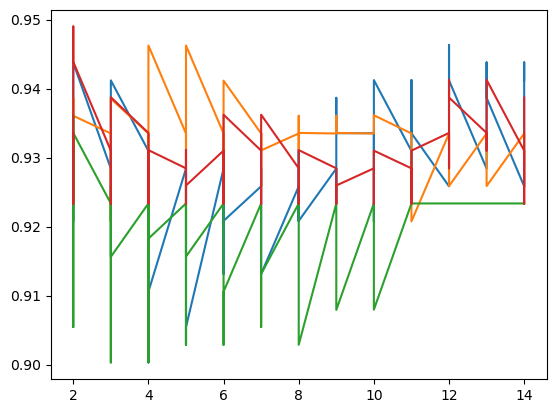

In [430]:
'''
IMPORTANT CONCEPT:

- need to tune tree...find best depth/min samples per leaf

- cross-validation at each depth is done on 100 different random training sets and the average accuracy at each is recorded

- graph shows best accuracy

- depths changing often with changes in data...

'''
clf_samps = []
clf_depths = []
#set train and test data
for df in [df_a, df_b, df_c, df_d]:
    df=df.sample(frac=1) 
    train_proportion = 0.8 
    n = len(df)
    t = int(train_proportion * n)

    # separate training and test sets
    y = df['detected']
    X = df.loc[:, ~df.columns.isin(['detected'])]
    '''
    #features in training set
    train_x = X.iloc[:t,:].reset_index().iloc[:,1:]
    #features in test set
    test_x = X.iloc[t:,:].reset_index().iloc[:,1:]
    #targets in train set
    train_y = pd.Series(y[:t].reset_index().iloc[:,1:].iloc[:,0])
    #targets in test set
    test_y = pd.Series(y[t:].reset_index().iloc[:,1:].iloc[:,0])
    '''
    # define the depths and samples
    samps = np.arange(2,15)
    depths = np.arange(2,15)
    # create an empty data frame for our results
    results = np.zeros(len(samps) * len(depths))
    test = pd.DataFrame(index = range(len(results)), columns=['samps','depths','accuracy'])
    for j in range(len(samps)):
        for k in range(len(depths)):
            tree = DecisionTreeClassifier(max_depth = depths[k], min_samples_leaf=samps[j]) # creating an instance of a decision tree
            test.loc[j*13 + k%13, :] = [samps[j], depths[k],cross_val_score(tree, X, y, scoring="accuracy", cv=6).mean()] # getting the cv accuracy metric for the tree at each depth


    test['accuracy'] = test['accuracy'].astype(float)                     
    depth = test.loc[test.accuracy.argmax(),'depths']
    samp = test.loc[test.accuracy.argmax(),'samps']
    print(test.loc[test.accuracy.argmax(),'accuracy'])
    clf_samps = np.append(clf_samps,samp)
    clf_depths = np.append(clf_depths,depth)
    plt.plot(test.samps, test.accuracy)

In [431]:
# define tree depth/samps
clf_samps=clf_samps.astype(int)
clf_depths=clf_depths.astype(int)
a_depth = clf_depths[0]
a_samp = clf_samps[0]
b_depth = clf_depths[1]
b_samp = clf_samps[1]
c_depth = clf_depths[2]
c_samp = clf_samps[2]
d_depth = clf_depths[3]
d_samp = clf_samps[3]
rs = 42
#clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 3)

# final df for display
dfr = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Avg. Train %', 'Avg. Validation %', 'Avg. Test %',
                                                                    'Best Sc. Train %', 'Best Sc. Validation %', 'Best Sc. Test %'])

In [432]:
'''
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.datasets import load_iris

iris = load_iris()
X, y = iris.data[:, [0,1,2]], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)


clf = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state= 0, min_samples_leaf=500)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))
'''

'\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.ensemble import GradientBoostingClassifier\nfrom sklearn.datasets import load_iris\n\niris = load_iris()\nX, y = iris.data[:, [0,1,2]], iris.target\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)\n\n\nclf = GradientBoostingClassifier(n_estimators = 100, max_depth = 10, random_state= 0, min_samples_leaf=500)\nclf.fit(X_train,y_train)\nprint(clf.score(X_train,y_train))\nprint(clf.score(X_test,y_test))\n'

In [433]:
'''
# Get the tree number 42
sub_tree_42 = clf.estimators_[7, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)
'''

'\n# Get the tree number 42\nsub_tree_42 = clf.estimators_[7, 0]\n\n# Visualization\n# Install graphviz: https://www.graphviz.org/download/\nfrom pydotplus import graph_from_dot_data\nfrom IPython.display import Image\nfrom sklearn.tree import export_graphviz\ndot_data = export_graphviz(\n    sub_tree_42,\n    out_file=None, filled=True, rounded=True,\n    special_characters=True,\n    proportion=False, impurity=False, # enable them if you want\n)\ngraph = graph_from_dot_data(dot_data)\npng = graph.create_png()\nImage(png)\n'

In [434]:
'''
df_a

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = a_depth, random_state= rs, min_samples_leaf = a_samp)
a_train =[]
a_vals =[]
a_tests=[]
j = 50
fi_a = np.zeros((len(df_a.columns) - 1))
a_pi = pd.DataFrame(index = range(j * 10),columns=df_a.iloc[:,:df_a.shape[1] - 1].columns)
a_tfpn_avg = pd.DataFrame(data = np.zeros((1,4)),columns = ['true positive', 'true negative', 'false positive', 'false negative'])
for i in range(j):
    model, train_acc, val_acc, test_acc, tfpn, pi = f.kfold_crossval(df_a, clf, 'bagging')
    a_train = np.append(train_acc, a_train)
    a_vals = np.append(val_acc, a_vals)
    a_tests = np.append(test_acc, a_tests)
    fi_a += model.feature_importances_
    a_tfpn_avg += tfpn

    for col in a_pi.columns:
       a_pi.loc[i*10:(i*10)+9, col] = np.array(pi[col])
        
    # keep best model
    if test_acc >= np.max(a_tests):
        a_model = model
        a_train_best = train_acc
        a_val_best = val_acc
        a_test_best = test_acc
        a_tfpn_best = tfpn
    elif test_acc <= np.min(a_tests):
        a_tfpn_worst = tfpn
        a_test_worst = test_acc

# average feature importances and tfpn's
fi_a /= i
a_tfpn_avg /= i


# get average accuracies
a_train_avg = round(np.mean(a_train),1)
a_vals_avg = round(np.mean(a_vals),1)
a_tests_avg = round(np.mean(a_tests),1)

print(f'{a_name} - Results:')
print(f'Best Scenario Training Accuracy: {a_train_best}%')
print(f'Average Training Accuracy: {a_train_avg}%')
print(f'Best Scenario Validation Accuracy: {a_val_best}%')
print(f'Average Validation Accuracy: {a_vals_avg}%')
print(f'Best Scenario Test Accuracy: {a_test_best}%')
print(f'Worst Scenario Test Accuracy: {a_test_worst}%')
print(f'Average Test Accuracy: {a_tests_avg}%')

All - Results:
Best Scenario Training Accuracy: 97.0%
Average Training Accuracy: 97.6%
Best Scenario Validation Accuracy: 97.4%
Average Validation Accuracy: 96.4%
Best Scenario Test Accuracy: 97.5%
Worst Scenario Test Accuracy: 86.1%
Average Test Accuracy: 93.4%


(-0.05, 0.2)

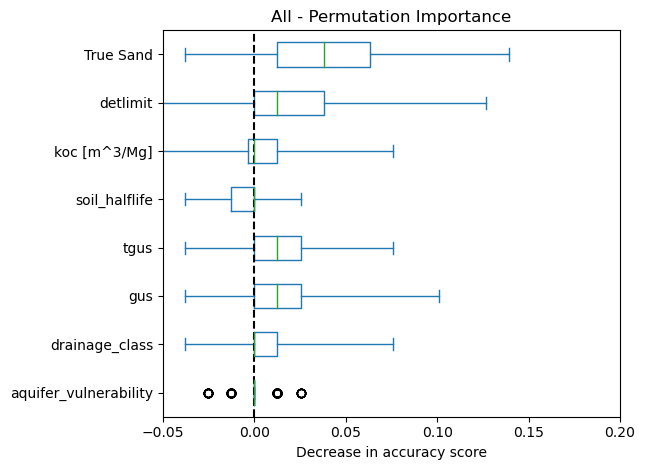

In [435]:
a_pi = a_pi.astype(float)
ax = a_pi.plot.box(vert=False, whis=10)
ax.set_title(f"{a_name} - Permutation Importance")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.set_xlim(-.05,.20)

In [436]:
'''
# Get the tree number 42
sub_tree_42 = a_model.estimators_[6, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)
'''

'\n# Get the tree number 42\nsub_tree_42 = a_model.estimators_[6, 0]\n\n# Visualization\n# Install graphviz: https://www.graphviz.org/download/\nfrom pydotplus import graph_from_dot_data\nfrom IPython.display import Image\nfrom sklearn.tree import export_graphviz\ndot_data = export_graphviz(\n    sub_tree_42,\n    out_file=None, filled=True, rounded=True,\n    special_characters=True,\n    proportion=False, impurity=False, # enable them if you want\n)\ngraph = graph_from_dot_data(dot_data)\npng = graph.create_png()\nImage(png)\n'

In [437]:
'''
df_b

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = b_depth, random_state= rs, min_samples_leaf = b_samp)
b_train =[]
b_vals =[]
b_tests=[]
j = 50
fi_b = np.zeros((len(df_b.columns) - 1))
b_tfpn_avg = pd.DataFrame(data = np.zeros((1,4)),columns = ['true positive', 'true negative', 'false positive', 'false negative'])
b_pi = pd.DataFrame(index = range(j * 10),columns=df_b.iloc[:,:df_b.shape[1] - 1].columns)
for i in range(j):
    model, train_acc, val_acc, test_acc, tfpn, pi = f.kfold_crossval(df_b, clf, 'bagging')
    b_train = np.append(train_acc, b_train)
    b_vals = np.append(val_acc, b_vals)
    b_tests = np.append(test_acc, b_tests)
    fi_b += model.feature_importances_
    b_tfpn_avg += tfpn

    for col in b_pi.columns:
       b_pi.loc[i*10:(i*10)+9, col] = np.array(pi[col])

    # keep best model
    if test_acc >= np.max(b_tests):
        b_model = model
        b_train_best = train_acc
        b_val_best = val_acc
        b_test_best = test_acc
        b_tfpn_best = tfpn
    elif test_acc <= np.min(b_tests):
        b_tfpn_worst = tfpn
        b_test_worst = test_acc

# keep feature importances
fi_b /= i
b_tfpn_avg /= i

# get average accuracies
b_train_avg = round(np.mean(b_train),1)
b_vals_avg = round(np.mean(b_vals),1)
b_tests_avg = round(np.mean(b_tests),1)

print(f'{b_name} - Results:')
print(f'Best Scenario Training Accuracy: {b_train_best}%')
print(f'Average Training Accuracy: {b_train_avg}%')
print(f'Best Scenario Validation Accuracy: {b_val_best}%')
print(f'Average Validation Accuracy: {b_vals_avg}%')
print(f'Best Scenario Test Accuracy: {b_test_best}%')
print(f'Worst Scenario Test Accuracy: {b_test_worst}%')
print(f'Average Test Accuracy: {b_tests_avg}%')


GUS Focus - Results:
Best Scenario Training Accuracy: 96.2%
Average Training Accuracy: 96.8%
Best Scenario Validation Accuracy: 93.6%
Average Validation Accuracy: 96.0%
Best Scenario Test Accuracy: 97.5%
Worst Scenario Test Accuracy: 86.1%
Average Test Accuracy: 92.9%


(-0.05, 0.2)

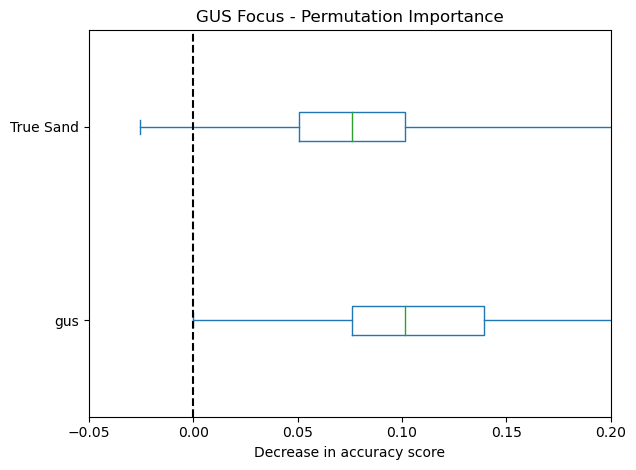

In [438]:
b_pi = b_pi.astype(float)
ax = b_pi.plot.box(vert=False, whis=10)
ax.set_title(f"{b_name} - Permutation Importance")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.set_xlim(-.05,.20)

In [439]:
'''
df_c

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = c_depth, random_state= rs, min_samples_leaf = c_samp)
c_train =[]
c_vals =[]
c_tests=[]
j = 50
fi_c = np.zeros((len(df_c.columns) - 1))
c_tfpn_avg = pd.DataFrame(data = np.zeros((1,4)),columns = ['true positive', 'true negative', 'false positive', 'false negative'])
c_pi = pd.DataFrame(index = range(j * 10),columns=df_c.iloc[:,:df_c.shape[1] - 1].columns)
for i in range(j):
    model, train_acc, val_acc, test_acc, tfpn, pi = f.kfold_crossval(df_c, clf, 'bagging')
    c_train = np.append(train_acc, c_train)
    c_vals = np.append(val_acc, c_vals)
    c_tests = np.append(test_acc, c_tests)
    fi_c += model.feature_importances_
    c_tfpn_avg += tfpn

    for col in c_pi.columns:
       c_pi.loc[i*10:(i*10)+9, col] = np.array(pi[col])

    # keep best model
    if test_acc >= np.max(c_tests):
        c_model = model
        c_train_best = train_acc
        c_val_best = val_acc
        c_test_best = test_acc
        c_tfpn_best = tfpn
    elif test_acc <= np.min(c_tests):
        c_tfpn_worst = tfpn
        c_test_worst = test_acc

# keep feature importances
fi_c /= i
c_tfpn_avg /= i

# get average accuracies
c_train_avg = round(np.mean(c_train),1)
c_vals_avg = round(np.mean(c_vals),1)
c_tests_avg = round(np.mean(c_tests),1)

print(f'{c_name} - Results:')
print(f'Best Scenario Training Accuracy: {c_train_best}%')
print(f'Average Training Accuracy: {c_train_avg}%')
print(f'Best Scenario Validation Accuracy: {c_val_best}%')
print(f'Average Validation Accuracy: {c_vals_avg}%')
print(f'Best Scenario Test Accuracy: {c_test_best}%')
print(f'Worst Scenario Test Accuracy: {c_test_worst}%')
print(f'Average Test Accuracy: {c_tests_avg}%')

TGUS Focus - Results:
Best Scenario Training Accuracy: 97.0%
Average Training Accuracy: 97.5%
Best Scenario Validation Accuracy: 96.2%
Average Validation Accuracy: 95.8%
Best Scenario Test Accuracy: 98.7%
Worst Scenario Test Accuracy: 87.3%
Average Test Accuracy: 92.6%


(-0.05, 0.2)

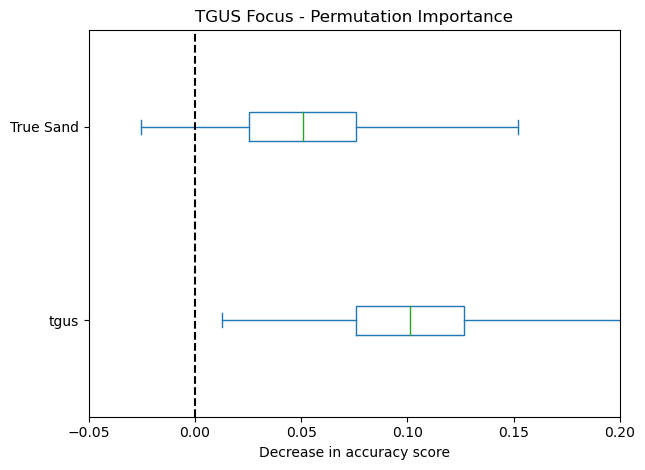

In [440]:
c_pi = c_pi.astype(float)
ax = c_pi.plot.box(vert=False, whis=10)
ax.set_title(f"{c_name} - Permutation Importance")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.set_xlim(-.05,.20)

In [441]:
'''
Considering just raw values with other features

clf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)
raw_train =[]
raw_vals =[]
raw_tests=[]
fi_raw = np.zeros((len(df_raw.columns) - 1))
for i in range(50):
    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')
    raw_train = np.append(train_acc, raw_train)
    raw_vals = np.append(val_acc, raw_vals)
    raw_tests = np.append(test_acc, raw_tests)
    fi_raw += model.feature_importances_

    # keep best model
    if test_acc >= np.max(raw_tests):
        raw_model = model
        raw_train_best = train_acc
        raw_val_best = val_acc
        raw_test_best = test_acc

# keep feature importances
fi_raw /= 50

# get average accuracies
raw_train_avg = round(np.mean(raw_train),1)
raw_vals_avg = round(np.mean(raw_vals),1)
raw_tests_avg = round(np.mean(raw_tests),1)

print('Raw - Results:')
print(f'Best Scenario Training Accuracy: {raw_train_best}%')
print(f'Average Training Accuracy: {raw_train_avg}%')
print(f'Best Scenario Validation Accuracy: {raw_val_best}%')
print(f'Average Validation Accuracy: {raw_vals_avg}%')
print(f'Best Scenario Test Accuracy: {raw_test_best}%')
print(f'Average Test Accuracy: {raw_tests_avg}%')

'''

"\nConsidering just raw values with other features\n\nclf = GradientBoostingClassifier(n_estimators = 100, max_depth = raw_depth, random_state= rs)\nraw_train =[]\nraw_vals =[]\nraw_tests=[]\nfi_raw = np.zeros((len(df_raw.columns) - 1))\nfor i in range(50):\n    model, train_acc, val_acc, test_acc = f.kfold_crossval(df_raw, clf, 'bagging')\n    raw_train = np.append(train_acc, raw_train)\n    raw_vals = np.append(val_acc, raw_vals)\n    raw_tests = np.append(test_acc, raw_tests)\n    fi_raw += model.feature_importances_\n\n    # keep best model\n    if test_acc >= np.max(raw_tests):\n        raw_model = model\n        raw_train_best = train_acc\n        raw_val_best = val_acc\n        raw_test_best = test_acc\n\n# keep feature importances\nfi_raw /= 50\n\n# get average accuracies\nraw_train_avg = round(np.mean(raw_train),1)\nraw_vals_avg = round(np.mean(raw_vals),1)\nraw_tests_avg = round(np.mean(raw_tests),1)\n\nprint('Raw - Results:')\nprint(f'Best Scenario Training Accuracy: {raw_tr

In [442]:
'''
df_d

'''
clf = GradientBoostingClassifier(n_estimators = 100, max_depth = d_depth, random_state= rs, min_samples_leaf = d_samp)
d_train =[]
d_vals =[]
d_tests=[]
j = 50
fi_d = np.zeros((len(df_d.columns) - 1))
d_tfpn_avg = pd.DataFrame(data = np.zeros((1,4)),columns = ['true positive', 'true negative', 'false positive', 'false negative'])
d_pi = pd.DataFrame(index = range(j * 10),columns=df_d.iloc[:,:df_d.shape[1] - 1].columns)
for i in range(j):
    model, train_acc, val_acc, test_acc, tfpn, pi = f.kfold_crossval(df_d, clf, 'bagging')
    d_train = np.append(train_acc, d_train)
    d_vals = np.append(val_acc, d_vals)
    d_tests = np.append(test_acc, d_tests)
    fi_d += model.feature_importances_
    d_tfpn_avg += tfpn

    for col in d_pi.columns:
       d_pi.loc[i*10:(i*10)+9, col] = np.array(pi[col])

    # keep best model
    if test_acc >= np.max(d_tests):
        d_model = model
        d_train_best = train_acc
        d_val_best = val_acc
        d_test_best = test_acc
        d_tfpn_best = tfpn
    elif test_acc <= np.min(d_tests):
        d_tfpn_worst = tfpn
        d_test_worst = test_acc

# keep feature importances
fi_d /= i
d_tfpn_avg /= i

# get average accuracies
d_train_avg = round(np.mean(d_train),1)
d_vals_avg = round(np.mean(d_vals),1)
d_tests_avg = round(np.mean(d_tests),1)

print(f'{d_name} - Results:')
print(f'Best Scenario Training Accuracy: {d_train_best}%')
print(f'Average Training Accuracy: {d_train_avg}%')
print(f'Best Scenario Validation Accuracy: {d_val_best}%')
print(f'Average Validation Accuracy: {d_vals_avg}%')
print(f'Best Scenario Test Accuracy: {d_test_best}%')
print(f'Worst Scenario Test Accuracy: {d_test_worst}%')
print(f'Average Test Accuracy: {d_tests_avg}%')


Raw - Results:
Best Scenario Training Accuracy: 97.0%
Average Training Accuracy: 97.5%
Best Scenario Validation Accuracy: 97.4%
Average Validation Accuracy: 96.7%
Best Scenario Test Accuracy: 98.7%
Worst Scenario Test Accuracy: 87.3%
Average Test Accuracy: 93.7%


(-0.05, 0.2)

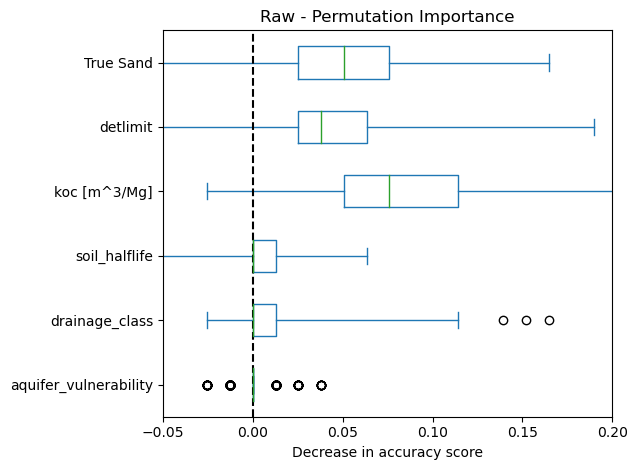

In [443]:
d_pi = d_pi.astype(float)
ax = d_pi.plot.box(vert=False, whis=10)
ax.set_title(f"{d_name} - Permutation Importance")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()
ax.set_xlim(-.05,.20)


In [444]:
# find total acc/tfpn
a_tot_acc, a_tfpn_tot = f.test_accuracy(modelName='bagging', test_x=df_a.iloc[:,:len(df_a.columns) - 1],test_y=df_a.iloc[:,-1], model=a_model)
b_tot_acc, b_tfpn_tot = f.test_accuracy(modelName='bagging', test_x=df_b.iloc[:,:len(df_b.columns) - 1],test_y=df_b.iloc[:,-1], model=b_model)
c_tot_acc, c_tfpn_tot = f.test_accuracy(modelName='bagging', test_x=df_c.iloc[:,:len(df_c.columns) - 1],test_y=df_c.iloc[:,-1], model=c_model)
d_tot_acc, d_tfpn_tot = f.test_accuracy(modelName='bagging', test_x=df_d.iloc[:,:len(df_d.columns) - 1],test_y=df_d.iloc[:,-1], model=d_model)

In [445]:

# final df to display results
dfr = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Avg. Train %', 'Avg. Validation %', 'Avg. Test %',
                                                                     'Best Test %', 'Worst Test &'])
dfr.loc[a_name,:] = [a_train_avg, a_vals_avg, a_tests_avg, a_test_best, a_test_worst]
dfr.loc[b_name,:] = [b_train_avg, b_vals_avg, b_tests_avg, b_test_best, b_test_worst]
dfr.loc[c_name,:] = [c_train_avg, c_vals_avg, c_tests_avg, c_test_best, c_test_worst]
dfr.loc[d_name,:] = [d_train_avg, d_vals_avg, d_tests_avg, d_test_best, d_test_worst]

# final df to display tfpn
dftfpn_avg = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Test %','True Positive', 'True Negative', 'False Positive', 'False Negative'])
dftfpn_avg.iloc[0,1:] = np.array(round(a_tfpn_avg.loc[0,:],2))
dftfpn_avg.iloc[1,1:] = np.array(round(b_tfpn_avg.loc[0,:],2))
dftfpn_avg.iloc[2,1:] = np.array(round(c_tfpn_avg.loc[0,:],2))
dftfpn_avg.iloc[3,1:] = np.array(round(d_tfpn_avg.loc[0,:],2))
dftfpn_avg['Test %'] = [a_tests_avg, b_tests_avg, c_tests_avg, d_tests_avg]

# final df to display tfpn
dftfpn_best = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Test %','True Positive', 'True Negative', 'False Positive', 'False Negative'])
dftfpn_best.iloc[0,1:] = np.array(round(a_tfpn_best.loc[0,:],2))
dftfpn_best.iloc[1,1:] = np.array(round(b_tfpn_best.loc[0,:],2))
dftfpn_best.iloc[2,1:] = np.array(round(c_tfpn_best.loc[0,:],2))
dftfpn_best.iloc[3,1:] = np.array(round(d_tfpn_best.loc[0,:],2))
dftfpn_best['Test %'] = [a_test_best, b_test_best, c_test_best, d_test_best]

# final df to display tfpn
dftfpn_worst = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Test %','True Positive', 'True Negative', 'False Positive', 'False Negative'])
dftfpn_worst.iloc[0,1:] = np.array(round(a_tfpn_worst.loc[0,:],2))
dftfpn_worst.iloc[1,1:] = np.array(round(b_tfpn_worst.loc[0,:],2))
dftfpn_worst.iloc[2,1:] = np.array(round(c_tfpn_worst.loc[0,:],2))
dftfpn_worst.iloc[3,1:] = np.array(round(d_tfpn_worst.loc[0,:],2))
dftfpn_worst['Test %'] = [a_test_worst, b_test_worst, c_test_worst, d_test_worst]

# final df to display tfpn
dftfpn_best_tot = pd.DataFrame(index=[a_name, b_name, c_name, d_name], columns=['Test %','True Positive', 'True Negative', 'False Positive', 'False Negative'])
dftfpn_best_tot.iloc[0,1:] = np.array(round(a_tfpn_tot.loc[0,:],2))
dftfpn_best_tot.iloc[1,1:] = np.array(round(b_tfpn_tot.loc[0,:],2))
dftfpn_best_tot.iloc[2,1:] = np.array(round(c_tfpn_tot.loc[0,:],2))
dftfpn_best_tot.iloc[3,1:] = np.array(round(d_tfpn_tot.loc[0,:],2))
dftfpn_best_tot['Test %'] = [a_tot_acc, b_tot_acc, c_tot_acc, d_tot_acc]

print(" "*56 + 'Model Results')
print(tabulate(dfr, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

print(" "*33 + 'Average of Models - True/False Positive/Negatives on Test Data')
print(tabulate(dftfpn_avg, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

print(" "*30 + 'Best Model - True/False Positive/Negatives on Test Data')
print(tabulate(dftfpn_best, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

print(" "*30 + 'Best Model - True/False Positive/Negatives on Total Dataset')
print(tabulate(dftfpn_best_tot, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))

print(" "*30 + 'Worst Model - True/False Positive/Negatives on Test Data')
print(tabulate(dftfpn_worst, headers='keys', tablefmt = 'fancy_grid', numalign = 'center'))



                                                        Model Results
╒════════════╤════════════════╤═════════════════════╤═══════════════╤═══════════════╤════════════════╕
│            │  Avg. Train %  │  Avg. Validation %  │  Avg. Test %  │  Best Test %  │  Worst Test &  │
╞════════════╪════════════════╪═════════════════════╪═══════════════╪═══════════════╪════════════════╡
│ All        │      97.6      │        96.4         │     93.4      │     97.5      │      86.1      │
├────────────┼────────────────┼─────────────────────┼───────────────┼───────────────┼────────────────┤
│ GUS Focus  │      96.8      │         96          │     92.9      │     97.5      │      86.1      │
├────────────┼────────────────┼─────────────────────┼───────────────┼───────────────┼────────────────┤
│ TGUS Focus │      97.5      │        95.8         │     92.6      │     98.7      │      87.3      │
├────────────┼────────────────┼─────────────────────┼───────────────┼───────────────┼────────────────┤
│ R

/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_85129/3050028793.py:21: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_85129/3050028793.py:28: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_85129/3050028793.py:28: UserWarning:

The palette list has more values (6) than needed (2), which may not be intended.

/var/folders/31/n7d1lkjj6y1_lcp76m8nrtbh0000gn/T/ipykernel_85129/3050028793.py:35: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.


/var/folders/31/n

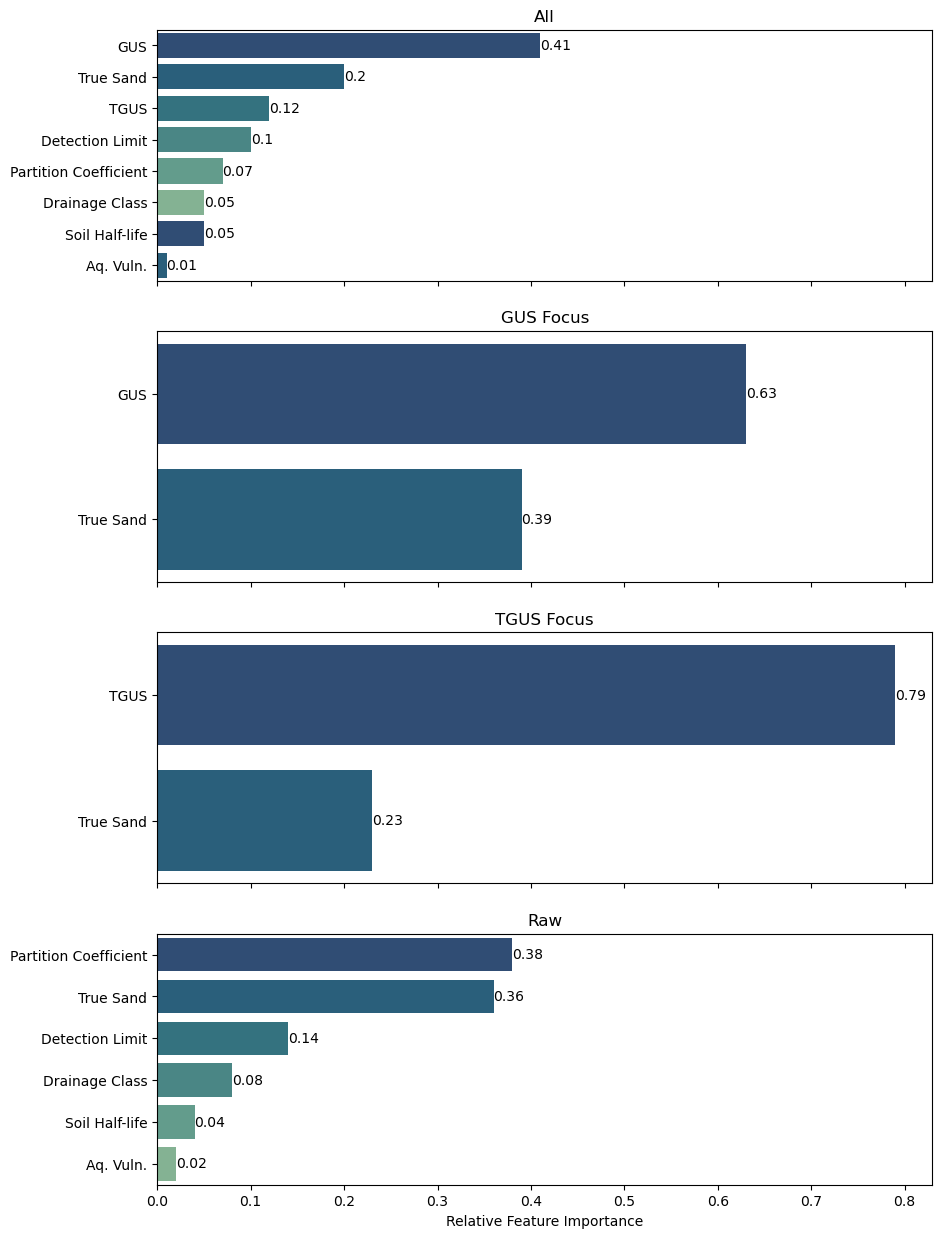

In [446]:
'''setup figures for plotting'''
fig, ([axA, axB, axC, axD]) = plt.subplots(nrows=4, ncols=1, figsize =(10,15), sharex = True)

axB.set_title(b_name,fontsize=12)
axC.set_title(c_name,fontsize=12)
axA.set_title(a_name,fontsize=12)
axD.set_title(d_name,fontsize=12)


y_dict = {'detlimit': 'Detection Limit', 'gus': 'GUS', 'koc [m^3/Mg]':'Partition Coefficient', 'tgus':'TGUS', 'medium':'Medium Aq. Vuln.', 'soil_halflife': 'Soil Half-life', 
        'high':'High Aq. Vuln.', 'Poorly drained':'Poorly Drained', 'Well drained':'Well Drained', 'Moderately well drained':'Moderately Well Drained', 
        'Somewhat poorly drained':'Somewhat Poorly Drained', 'low':'Low Aq. Vuln.', 'Very poorly drained':'Very Poorly Drained', 'Somewhat excessively drained':'Somewhat Excessively Drained',
        'offset':'Offset', 'aquifer_vulnerability': 'Aq. Vuln.', 'drainage_class':'Drainage Class', 'Sand %': 'Sand %', 'Silt %': 'Silt %', 'Clay %': 'Clay %',
        'True Sand':'True Sand', 'True Silt':'True Silt', 'True Clay':'True Clay'}

pal = sns.color_palette('crest_r')

fi_d = pd.Series(np.round(fi_d,2), index = df_d.drop('detected', axis = 1).columns)
fi_d = fi_d.sort_values(ascending=False)
arr=np.array(fi_d.index)
axD=sns.barplot(ax=axD,x=np.array(fi_d.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axD.containers:
    axD.bar_label(i,)

fi_c = pd.Series(np.round(fi_c,2), index = df_c.drop('detected', axis = 1).columns)
fi_c = fi_c.sort_values(ascending=False)
arr=np.array(fi_c.index)
axC=sns.barplot(ax=axC,x=np.array(fi_c.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
for i in axC.containers:
    axC.bar_label(i,)

fi_b = pd.Series(np.round(fi_b,2), index = df_b.drop('detected', axis = 1).columns)
fi_b = fi_b.sort_values(ascending=False)
arr=np.array(fi_b.index)
axB=sns.barplot(ax=axB,x=np.array(fi_b.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr),palette = pal)
for i in axB.containers:
    axB.bar_label(i,)

fi_a = pd.Series(np.round(fi_a,2), index = df_a.drop('detected', axis = 1).columns)
fi_a = fi_a.sort_values(ascending=False)
arr=np.array(fi_a.index)
axA=sns.barplot(ax=axA,x=np.array(fi_a.loc[:]), y= np.vectorize(lambda k: y_dict[k])(arr), palette = pal)
axD.set_xlabel('Relative Feature Importance')
for i in axA.containers:
    axA.bar_label(i,)



In [447]:
'''
Equal variance t-tests to compare result means
'''
cols = [a_name, b_name, c_name, d_name]
train_scores = pd.DataFrame({a_name: a_train, b_name: b_train, c_name: c_train, d_name: d_train})
val_scores = pd.DataFrame({a_name: a_vals, b_name: b_vals, c_name: c_vals, d_name: d_vals})
test_scores = pd.DataFrame({a_name: a_tests, b_name: b_tests, c_name: c_tests, d_name: d_tests})

comp_train = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_val = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )
comp_test = pd.DataFrame(columns = train_scores.columns, index = train_scores.columns )

for i in cols:
    for j in cols:
        stat_train,p_train = sts.ttest_ind(train_scores.loc[:,i], train_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_train.loc[i,j] = [round(p_train,100)]

        stat_val,p_val = sts.ttest_ind(val_scores.loc[:,i], val_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_val.loc[i,j] = [round(p_val,100)]

        stat_test,p_test = sts.ttest_ind(test_scores.loc[:,i], test_scores.loc[:,j], equal_var = True, alternative = 'two-sided')
        comp_test.loc[i,j] = [round(p_test,100)]

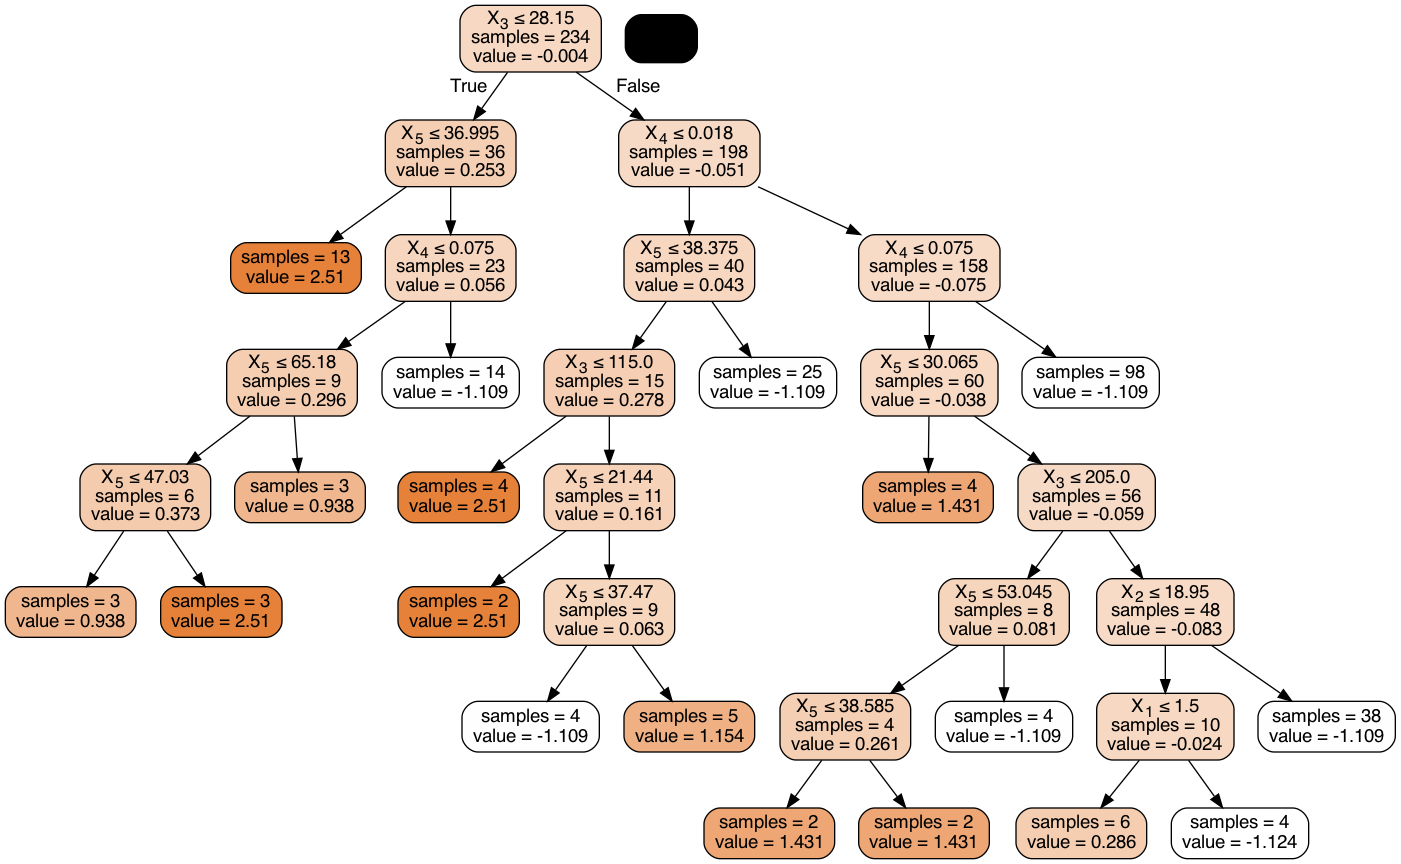

In [448]:
# Get the tree number 42
sub_tree_42 = d_model.estimators_[3, 0]

# Visualization
# Install graphviz: https://www.graphviz.org/download/
from pydotplus import graph_from_dot_data
from IPython.display import Image
from sklearn.tree import export_graphviz
dot_data = export_graphviz(
    sub_tree_42,
    out_file=None, filled=True, rounded=True,
    special_characters=True,
    proportion=False, impurity=False, # enable them if you want
)
graph = graph_from_dot_data(dot_data)
png = graph.create_png()
Image(png)

In [449]:
df_b_graph = df_b.copy()
df_b_graph['detected'].replace(to_replace=1, value='detect',inplace=True)
df_b_graph['detected'].replace(to_replace=-1, value='nondetect',inplace=True)
print(df_b_graph.detected)

0      nondetect
1      nondetect
2      nondetect
3      nondetect
4      nondetect
         ...    
386    nondetect
387    nondetect
388    nondetect
389    nondetect
390    nondetect
Name: detected, Length: 391, dtype: object


In [450]:
colors = {"detect": "orange", "nondetect": "blue"}

for i in df_b_graph.detected.unique():

    globals()[f"Data_{i}"]=go.Scatter3d(
        x=df_b_graph.loc[df_b_graph.detected == i ,"gus"],
        y=df_b_graph.loc[df_b_graph.detected == i ,"drainage_class"],
        z=df_b_graph.loc[df_b_graph.detected == i ,"detlimit"],
        name=i,
        hovertemplate='gus: %{x} <br>' + \
            'drainage_class: %{y} <br>' + \
            'detlimit: %{z} <br>' + \
            'detected: {0}'.format(i),
        mode='markers',
        marker=dict(
            size=3,
            color=colors[i],           
            opacity=0.8
        )
    )
        
fig = go.Figure(data=[Data_detect, Data_nondetect])

camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=-1, y=-1.75, z=1.5)
)

fig.update_layout(
    scene_camera=camera,
    autosize=True,
    template="plotly_white",
    scene={
        "xaxis_title":r'GUS',
        "yaxis_title":r'Drainage Class',
        "zaxis_title":r'Detection limit'
    },
    width=800, height=800,
    showlegend=True,
    title="IRIS Data in 3D"
)

fig.show()

KeyError: 'drainage_class'